In [1]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import rawpy
import cv2
import imageio as iio
from scipy import signal
import glob
import os

In [2]:
image_1=io.imread("./01/IMG_9939.JPG")
image_1.shape

(4000, 6000, 3)

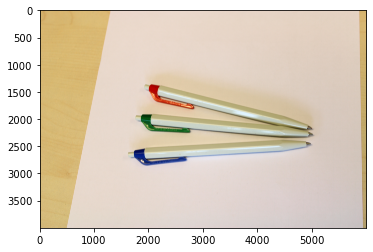

In [3]:
plt.imshow(image_1)

In [4]:
image_array=np.load("./01/IMG_9939.npy")
image_array.shape

(4014, 6020)

# Exercise 1: Investigate Bayer Patterns

In [5]:
# Different Bayer Patterns

def BGGR():
    m_red = np.array([[0, 0], [0, 1]])
    m_green = np.array([[0,1], [1, 0]])
    m_blue = np.array([[1, 0], [0, 0]])
    
    return m_red,m_green,m_blue

def GBRG():
    m_red = np.array([[0, 0], [1, 0]])
    m_green = np.array([[1,0], [0, 1]])
    m_blue = np.array([[0, 1], [0, 0]])
    
    return m_red,m_green,m_blue

def GRBG():
    m_red = np.array([[0, 1], [0, 0]])
    m_green = np.array([[1,0], [0, 1]])
    m_blue = np.array([[0, 0], [1, 0]])
    
    return m_red,m_green,m_blue

def RGGB():
    m_red = np.array([[1, 0], [0, 0]])
    m_green = np.array([[0,1], [1, 0]])
    m_blue = np.array([[0, 0], [0, 1]])
    
    return m_red,m_green,m_blue

In [6]:
# Kernel for Bilinear Interpolation
kernel = np.array([[0.25, 0.5, 0.25],
                       [0.5, 1, 0.5],
                       [0.25, 0.5, 0.25]])

# Excercise 2.2:  Prove that Sensor Data is Linear

In this exercise we are checking that the sensor data is linear,we are doing this by taking average values of green, red and blue pixels in raw sensor data. And plotting it as a function of exposure time.

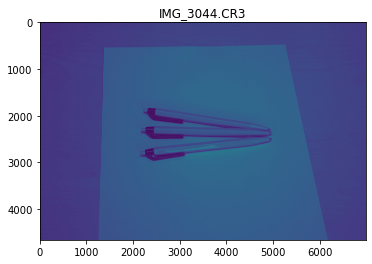

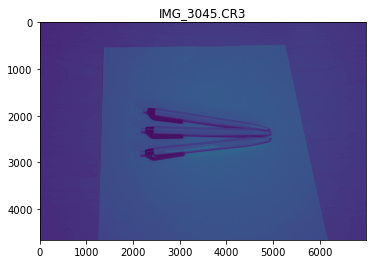

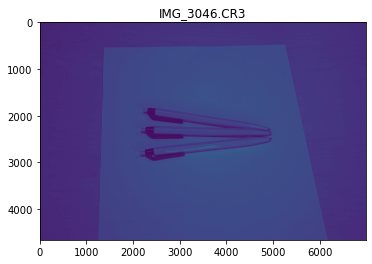

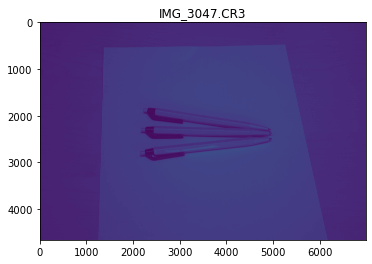

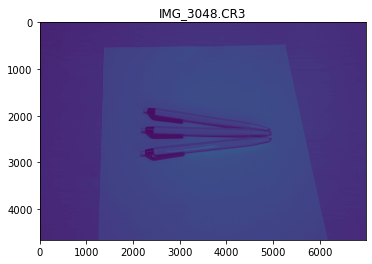

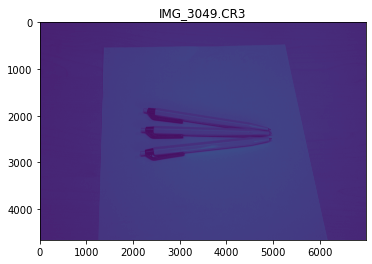

In [7]:
file_path="./02/"
raw_files=glob.glob(file_path+ "/*.CR3")
raw_files.sort()

raw_images=[]
raw_name=[]

for file in raw_files:
    with rawpy.imread(file) as raw:
        raw_images.append(np.array(raw.raw_image_visible))
        raw_name.append(file.split("/")[-1])

for i,j in zip(raw_images,raw_name):
    plt.figure()
    plt.imshow(i)
    plt.title(j)
    plt.show()

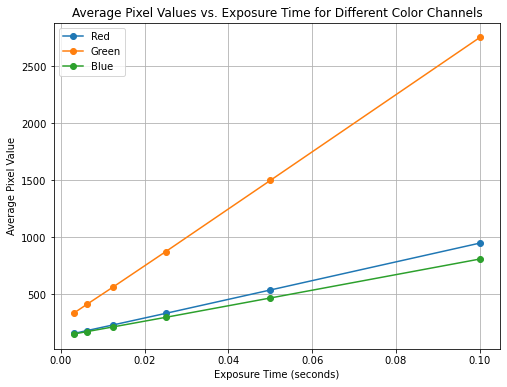

In [8]:
# Assuming the CFA is RGGB
r_mask,g_mask,b_mask=RGGB()

# For Generating masks for RGB colors
tile_rows = raw_images[0].shape[0] // 2
tile_cols = raw_images[0].shape[1] // 2
mask_red = np.tile(r_mask, (tile_rows, tile_cols))
mask_green = np.tile(g_mask, (tile_rows, tile_cols))
mask_blue = np.tile(b_mask, (tile_rows, tile_cols))


# Exposure times in seconds
exposure_times = [1/10, 1/20, 1/40, 1/80, 1/160, 1/320]

# Arrays to store average pixel values for each color channel
avg_red = []
avg_green = []
avg_blue = []

# Loop through each image
for file in raw_files:
    raw = rawpy.imread(file)
    
    array = np.array(raw.raw_image_visible)
    
    # To get only respective color values
    red_color=np.multiply(mask_red,array)
    green_color=np.multiply(mask_green,array)
    blue_color=np.multiply(mask_blue,array)

    # Calculate average pixel values for each color channel
    avg_red.append(np.mean(red_color))
    avg_green.append(np.mean(green_color))
    avg_blue.append(np.mean(blue_color))

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(exposure_times, avg_red, marker='o', label='Red')
plt.plot(exposure_times, avg_green, marker='o', label='Green')
plt.plot(exposure_times, avg_blue, marker='o', label='Blue')

plt.xlabel('Exposure Time (seconds)')
plt.ylabel('Average Pixel Value')
plt.title('Average Pixel Values vs. Exposure Time for Different Color Channels')
plt.legend()
plt.grid(True)
plt.show()


# Excercise 2.3:  Demosaicing algorithm as explained in lecture slides.
Here we are creating a function demosaic which takes raw image and integer value denoting which type of CFA is used in the camera sensor.

In [9]:
raw=rawpy.imread("./03/IMG_4782.CR3")
img3_array=np.array(raw.raw_image_visible)

In [29]:
# Normalization function for raw data 
def normalize(image):
    # Normalize the image using min-max normalization to scale pixel values between 0 and 255
    normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return normalized

# Demosaicing function for Bayer filter pattern
# Filter choices: 0 for BGGR, 1 for GBRG, 2 for GRBG, 3 for RGGB
def demosaic(image):
    # Bayer filter masks for red, green, and blue channels
    m_red, m_green, m_blue = RGGB()
    
    # Normalize the raw data as it is typically represented in 14 bits
    normalized_image = image

    # Calculate tile sizes for Bayer filter pattern
    tile_rows = normalized_image.shape[0] // 2
    tile_cols = normalized_image.shape[1] // 2
    
    # Generate masks for each color channel
    mask_red = np.tile(m_red, (tile_rows, tile_cols))
    mask_green = np.tile(m_green, (tile_rows, tile_cols))
    mask_blue = np.tile(m_blue, (tile_rows, tile_cols))
    
    # Multiply the masks with the normalized image to obtain weighted sum for each channel
    M_R = np.multiply(mask_red, normalized_image)
    M_G = np.multiply(mask_green, normalized_image)
    M_B = np.multiply(mask_blue, normalized_image)

    # Convolve the weighted sum with the kernel
    first_r = signal.convolve(M_R, kernel, mode='same')
    first_g = signal.convolve(M_G, kernel, mode='same')
    first_b = signal.convolve(M_B, kernel, mode='same')

    # Convolve the masks with the kernel
    second_r = signal.convolve(mask_red, kernel, mode='same')
    second_g = signal.convolve(mask_green, kernel, mode='same')
    second_b = signal.convolve(mask_blue, kernel, mode='same')

    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-6
    second_r[second_r == 0] = epsilon
    second_g[second_g == 0] = epsilon
    second_b[second_b == 0] = epsilon
    
    # Compute the final color channels by dividing the convolutions
    red_channel = np.divide(first_r, second_r)
    green_channel = np.divide(first_g, second_g)
    blue_channel = np.divide(first_b, second_b)

    # Combine the color channels to form the demosaiced image
    combined_image = np.dstack((red_channel, green_channel, blue_channel))

    return combined_image


In [30]:
demosaiced_img=demosaic(img3_array)

# Exercise 2.4 : Improve the Luminosity

In [12]:
def luminosity(image):
    a = np.percentile(image, 0.01)
    b = np.percentile(image, 99.99)
    lum_img = (image - a) / (b-a)
    lum_img[lum_img<0] = 0
    lum_img[lum_img>1] = 1
    lum_image=np.power(lum_img,0.5)
    
    return lum_image

# Excercise 2.5:  White Balance


In [13]:
def white_balance(image):
    image_mean = np.mean(image)
    image_red_mean = np.mean(image[:,:,0])
    image_green_mean = np.mean(image[:,:,1])
    image_blue_mean = np.mean(image[:,:,2])

    balanced_red = np.multiply(image[:,:,0], np.divide(image_mean, image_red_mean, where=(image_red_mean != 0)))
    balanced_green = np.multiply(image[:,:,1], np.divide(image_mean, image_green_mean, where=(image_green_mean != 0)))
    balanced_blue = np.multiply(image[:,:,2], np.divide(image_mean, image_blue_mean, where=(image_blue_mean != 0)))

    white_image = np.dstack((balanced_red, balanced_green, balanced_blue))
    white_image = np.clip(white_image, 0, 1)
    
    return white_image


In [14]:
luminosity_corrected=luminosity(demosaiced_img)
white_corrected_img=white_balance(luminosity_corrected)

Text(0.5, 1.0, 'White Balanced Image')

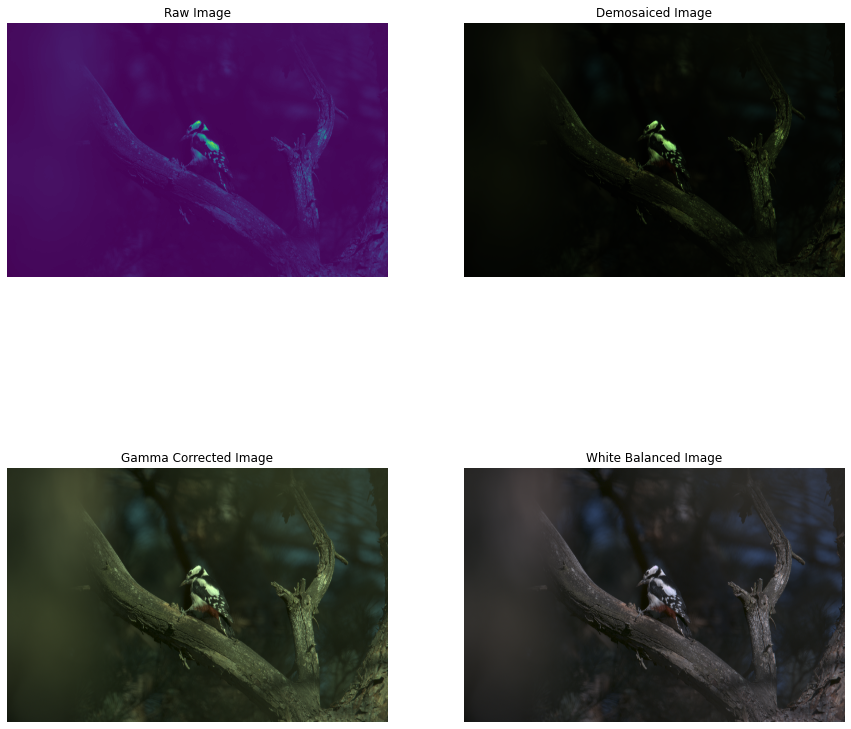

In [15]:
# For checking implementation

fig = plt.figure(figsize=(15, 15)) 
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)  
plt.imshow(img3_array) 
plt.axis('off') 
plt.title("Raw Image") 
  

fig.add_subplot(rows, columns, 2) 
plt.imshow(normalize(demosaiced_img)) 
plt.axis('off') 
plt.title("Demosaiced Image") 
  

fig.add_subplot(rows, columns, 3) 
plt.imshow(luminosity_corrected) 
plt.axis('off') 
plt.title("Gamma Corrected Image") 
  
fig.add_subplot(rows, columns, 4)  
plt.imshow(white_corrected_img) 
plt.axis('off') 
plt.title("White Balanced Image") 

# Exercise 2.6 : HDR Implementation.

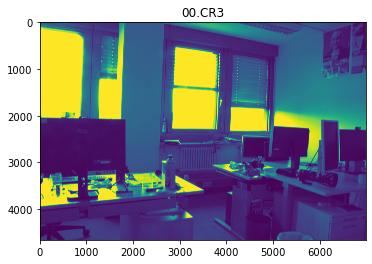

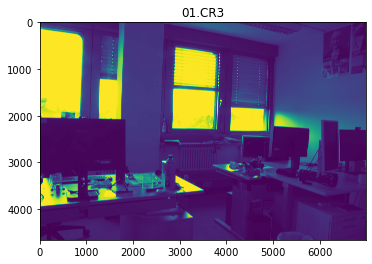

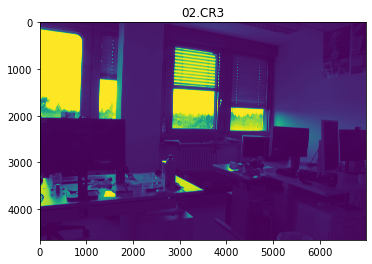

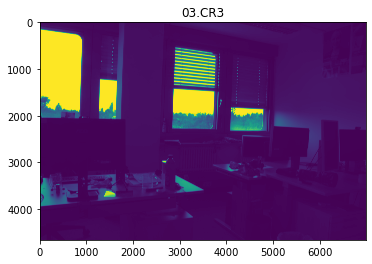

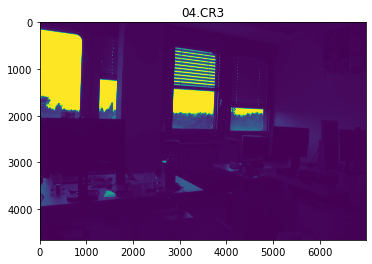

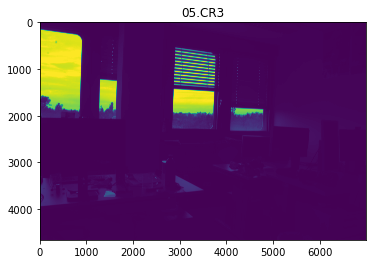

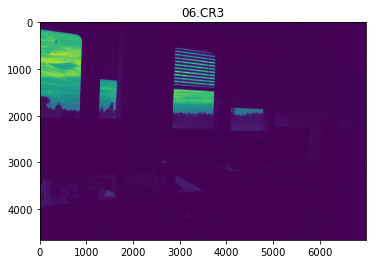

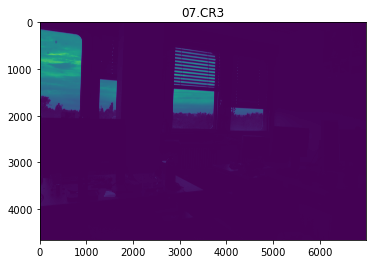

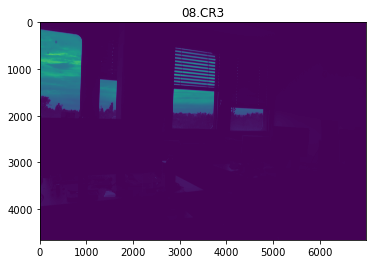

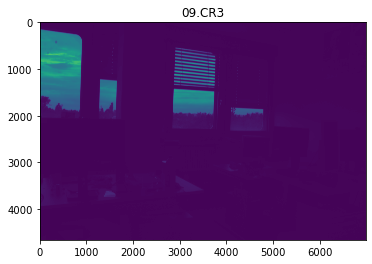

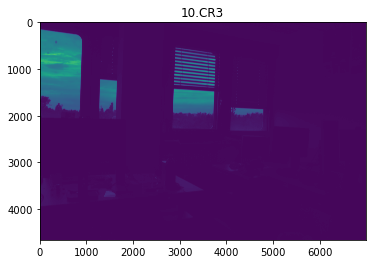

In [16]:
hdr_path="./06/"

hdr_files=glob.glob(hdr_path+ "/*.CR3")
hdr_files.sort()

hdr_images=[]
hdr_name=[]

for f in hdr_files:
    with rawpy.imread(f) as raw:
        hdr_images.append(np.array(raw.raw_image_visible))
        hdr_name.append(f.split("/")[-1])
        
for l,k in zip(hdr_images,hdr_name):
    plt.figure()
    plt.imshow(l)
    plt.title(k)
    plt.show()

In [31]:
hdr_files

['./06/00.CR3',
 './06/01.CR3',
 './06/02.CR3',
 './06/03.CR3',
 './06/04.CR3',
 './06/05.CR3',
 './06/06.CR3',
 './06/07.CR3',
 './06/08.CR3',
 './06/09.CR3',
 './06/10.CR3']

In [17]:
exposure_diff = np.array([1, 2.167, 4.0625, 8.125, 16.25, 32.5, 65, 130, 260, 520, 1040])
brightest_photo=np.copy(hdr_images[0])
'''
def hdr(images,exposure_diff):
    threshold = 0.8 * np.max(images[0])
    
    for idx in range(1, len(hdr_files)):
        current_photo = images[idx]
        current_photo = current_photo * exposure_diff[idx]
        mask = brightest_photo > threshold
        brightest_photo[mask] = current_photo[mask]
        
    return brightest_photo
'''

def log_scaling(img):
   
    hdr_log = np.log1p(img)
    hdr_normalized = ((hdr_log - np.min(hdr_log)) / (np.max(hdr_log) - np.min(hdr_log))) * 255
    log_scaled = hdr_normalized.astype(np.uint8)

    return log_scaled


In [49]:
def combine_exposure_images(brightest_image, raw_images, exposure_ratios, threshold_ratio=0.8):
    # Copy the brightest image to avoid modifying the original data
    combined_image = np.copy(brightest_image)

    # Iterate through each raw image and combine with the brightest image
    for i, raw_image in enumerate(raw_images):
        
        # Calculate exposure-adjusted image
        adjusted_image = raw_image * exposure_ratios[i]

        # Find indices where values in the brightest image are above the threshold
        threshold = threshold_ratio * np.max(combined_image)
        mask = combined_image > threshold

        # Replace values in the brightest image with corresponding values from the adjusted image
        combined_image[mask] = adjusted_image[mask]

    return combined_image

In [50]:
result_hdr=combine_exposure_images(brightest_photo,hdr_images[1:],exposure_diff[1:])

In [53]:
demosaic_hdr=demosaic(result_hdr)
final_image=log_scaling(demosaic_hdr)
lumin_hdr=luminosity(final_image)

white_corrected_hdr=white_balance(lumin_hdr)



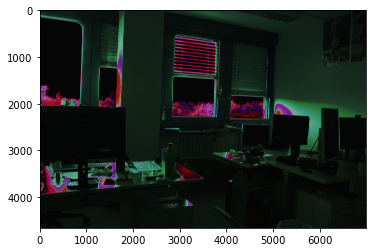

In [54]:
plt.imshow(normalize(demosaic_hdr))

In [57]:
np.min((demosaic_hdr))

-9.713349518952544e-12

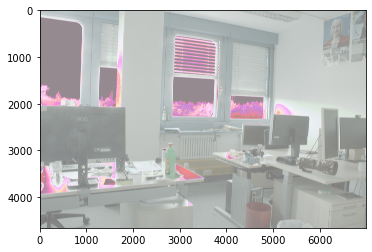

In [55]:
plt.imshow(white_corrected_hdr)

I am facing the issue regarding the final image, in this implemenation colors I am getting is not correct

In [23]:
exposure_diff = np.array([1, 2.167, 4.0625, 8.125, 16.25, 32.5, 65, 130, 260, 520, 1040])
threshold = 0.8 * np.max(hdr_images[0])
brightest_photo = hdr_images[0]

for idx in range(1, len(hdr_files)):
    current_photo = hdr_images[idx]
    current_photo = current_photo * exposure_diff[idx]

    # Replace values in the brightest photo with values from the current photo
    mask = brightest_photo > threshold
    brightest_photo[mask] = current_photo[mask]


In [24]:
bayer_image_1 = cv2.cvtColor(result_hdr, cv2.COLOR_BAYER_BG2BGR)
bayer_image_2 = cv2.cvtColor(result_hdr, cv2.COLOR_BAYER_GB2BGR)
bayer_image_3 = cv2.cvtColor(result_hdr, cv2.COLOR_BAYER_RG2BGR)
bayer_image_4 = cv2.cvtColor(result_hdr, cv2.COLOR_BAYER_GR2BGR)


image 1: RGGB pattern
image 2: GRBG pattern
image 3: BGGR
image 4: GBRG

In [25]:
lumin_hdr=luminosity(bayer_image_1)

white_corrected_hdr=white_balance(lumin_hdr)

final_image=log_scaling(white_corrected_hdr)

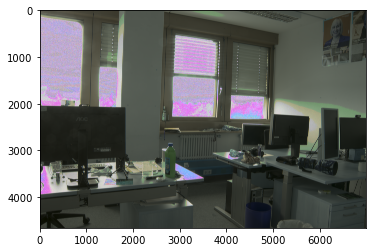

In [26]:
plt.imshow(final_image)